**Scraping detour**

As we saw last time "scraping data" means a process whereby data, stored in a format more suitable for presentation, are extracted and put in more regular format, suitable for computation. Web pages are written in HTML and are designed for display in web browsers -- they are formatted *as documents* with tags and CSS styling to control how information is rendered. The tags have to do with headings and paragraphs and lists and even tables, but they describe the content as elements of a document. Because of this, we have to work quite hard to find which document "meta-data" helps us find the information we are after.

So with the ArmsList example from last time, we had to specify a combination of HTML tags and CSS styling to pinpoint information about items for sale, their price and the location of the vendor. Implicitly we are relying on the fact that a machine is putting out HTML that is regular enough that we can find all the prices and locations and vendors on a page because they are all styled and described in HTML the same way.

We have not talked about it explicitly, but XML is a markup language (the eXtensible Markup Language) that removes all this insanity and formats data using tags that are more descriptive of the information they contain. Take for example the [COVID-19 data available from the EU Open Data Portal](https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data). There are various options for downloading the data, and it's worth looking at a couple. For the moment, let's focus on XML. Here are the first couple COVID cases in the XML file.

```
<records>
    <record>
        <dateRep>13/04/2020</dateRep>
        <day>13</day>
        <month>4</month>
        <year>2020</year>
        <cases>52</cases>
        <deaths>0</deaths>
        <countriesAndTerritories>Afghanistan</countriesAndTerritories>
        <geoId>AF</geoId>
        <countryterritoryCode>AFG</countryterritoryCode>
        <popData2018>37172386</popData2018>
    </record>
    <record>
        <dateRep>12/04/2020</dateRep>
        <day>12</day>
        <month>4</month>
        <year>2020</year>
        <cases>34</cases>
        <deaths>3</deaths>
        <countriesAndTerritories>Afghanistan</countriesAndTerritories>
        <geoId>AF</geoId>
        <countryterritoryCode>AFG</countryterritoryCode>
        <popData2018>37172386</popData2018>
    </record>
</records>
```

Notice that the tags are not based in pieces of a document (paragraphs, headings, tables, etc) but are descriptive of the data they contain. `<cases>` and `<popData2018>` and so on. This is said to be a "machine readble" format in that the descriptions can be brought right into something like BeautifulSoup or Pandas. 

Let's have a brief look. First, request the data and parse it with `BeautifulSoup()`. 

In [ ]:
from requests import get
from bs4 import BeautifulSoup

url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/xml/"
response = get(url)

cases = BeautifulSoup(response.text,features="xml")
type(cases)

Now, we can navigate the BeautifulSoup object just as we have been doing, but with tag names from our data, not HTML. Here we use `find_all()` to get all the `<record>` tags and then pull out the individual components. 

In [ ]:
records = cases.find_all("record")

print(records[0].dateRep.string)
print(records[0].countriesAndTerritories.string)
print(records[0].deaths.string)
print(records[0].cases.string)
print(records[0].popData2018.string)

So, how, to put this into a DataFrame? Well, unfortunately there is not a `read_xml()` function in pandas. So, we will create a list of lists, with each element in a big list being a record, represented as a list of the data from above. Things like deaths and cases and the country name. So here's a loop to run through the records and append the information to a growing list of lists.

In [ ]:
data = []

for record in records:
    newdata = [record.dateRep.string,
                record.countriesAndTerritories.string,
                record.deaths.string,
                record.cases.string,
                record.popData2018.string]
    data.append(newdata)
    
print(len(data))

And here are the first three entries...

In [ ]:
data[:3]

Now, the function `DataFrame()` takes a list of dictionaries or a list of lists to make a data frame. So, here we go...

In [ ]:
from pandas import DataFrame

cases = DataFrame(data,columns=["dateRep","country","deaths","cases","popData2018"])
cases.head()

In [ ]:
cases.to_csv("oo.csv",index=False)

Ta da! It's a little grubbier than reading a CSV directly, but XML can get complex. One last note. The API from the EU provides different ways to encode the same data. It's worth seeing how the formats compare. We can do that using [Mr. Data Converter](https://shancarter.github.io/mr-data-converter/). Copy the rows of the CSV below into the top window. Then select "XML-Nodes" from the second window. You should see our XML file back! You can also select JSON to see other representations. Play with this a little and see how the different formats (even the different ways of creating XML) structure the data. 

```
dateRep,country,deaths,cases,popData2018
13/04/2020,Afghanistan,0,52,37172386
12/04/2020,Afghanistan,3,34,37172386
11/04/2020,Afghanistan,0,37,37172386
10/04/2020,Afghanistan,1,61,37172386
09/04/2020,Afghanistan,3,56,37172386
08/04/2020,Afghanistan,4,30,37172386
07/04/2020,Afghanistan,0,38,37172386
```

But notice that in each case, the data are directly accessible. We are not fishing around in HTML to find a particular heading tag colored blue, say.

**PDFs**

In the COVID Tracking site, we saw that CT put out their daily updates in the form of a PDF. [Here is the one for 4/12](https://portal.ct.gov/-/media/Coronavirus/CTDPHCOVID19summary4122020.pdf?la=en). Download it. If you wanted to pull the one for 3/28, what might you do?

Just like HTML, PDF (the Portable Document Format) is really good for representing content as a document. In this case PDF is less focused on a browser than on formatting a document for a printer -- creating a standard like this was a huge deal when PDF was introduced. Often, however, it becomes a vehicle for publishing data and then you start to see its weaknesses. Extracting data from a PDF will depend, first, on the kind of PDF it is. If you can "select" text from the document, you're in luck. There are several tools to help you get reasonably close to the data. If, on the other hand, your pages are essentially images, well, then you have to rely on "optical character recognition" programs that cluster black and white pixels, say, into letters and words and sentences.

If I only have one PDF to pull tabular data from, I often use [Tabula](http://tabula.technology/) to convert it to something more usable, a CSV (comma separated values) file. Go ahead and download Tabula. 
<br><br>

<img src="https://github.com/computationaljournalism/columbia2020/raw/master/images/t1.jpeg" width=500 border=1>
<br><br>

Then load in the PDF from CT...
<br><br>

<img src="https://github.com/computationaljournalism/columbia2020/raw/master/images/t2.jpeg" width=500 border=1>
<br><br>

... and select the table you are interested in...
<br><br>

<img src="https://github.com/computationaljournalism/columbia2020/raw/master/images/t3.jpeg" width=500 border=1>
<br><br>

... and convert it to CSV.
<br><br>

<img src="https://github.com/computationaljournalism/columbia2020/raw/master/images/t4.jpeg" width=500>
<br><br>

We can now download it and read it into Pandas, for example. (Although we anticipate some problems -- which column might give us trouble?)

**Scraping a PDF in Python**

We are now going to scrape content out of a PDF. What kinds of data can we pull? We'll see that it has a lot to do with the metadata describing how text is to be rendered. We are going to use a package called `pdfplumber` that you'll have to install.

In [ ]:
!pip install pdfplumber

The `pdfplumber` package has a function called `open()`. To not confuse things with the ordinary Python command `open()` we are going to import `pdfplumber` slightly differently. Below we load CT's COVID report. It will expose an object called `pages` that is list like, one element per page. Here we pick the first page (index 0).

In [ ]:
import pdfplumber

pdf = pdfplumber.open("CTDPHCOVID19summary4122020.pdf")
page = pdf.pages[0]

The `page` object has several useful methods. The first will `extract_text()` from the page that we can then put through a regular expression filter. 

In [ ]:
page.extract_text()

In addition to pulling text, the `page` object has data. Like all the `chars` (characters) on the page. Let's look at the characters. What do you notice?

In [ ]:
page.chars

Yes! A list of dictionaries, one entry per letter! We can work with that. Like, um, putting it into a data frame! 

In [ ]:
from pandas import DataFrame

chars = DataFrame(page.chars)
chars.head()

Let's look at the fonts used in the doc. We see that some of the important information is in italics...

In [ ]:
chars["fontname"].value_counts()

In [ ]:
chars[chars["fontname"]=="BCDIEE+Calibri-Italic"]

Ha! Here we go further and get the tables. The `.extract_tables()` method creates a list-like object with one entry per table on the page. Each table is, in turn, a list of lists. Here are all the tables...

In [ ]:
page.extract_tables()

In [ ]:
table1 = page.extract_tables()[0]
table1

A list of lists. This we can read into a data frame. We are going to drop the first four entries in the big list because they stretch the title of each column out. We'll drop them and name the columns ourselves.

In [ ]:
from pandas import DataFrame

table1 = DataFrame(table1[4:],columns=["County","Cases","Deaths"])
table1

Finally, we can do some visual analysis to see how this tool is pulling characters into a strig of text.

/Users/mark/anaconda3/lib/python3.7/site-packages/wand/image.py:8313: ImageWarning: CorruptImageProfile `xmp' @ warning/profile.c/SetImageProfileInternal/1747
  self.raise_exception()


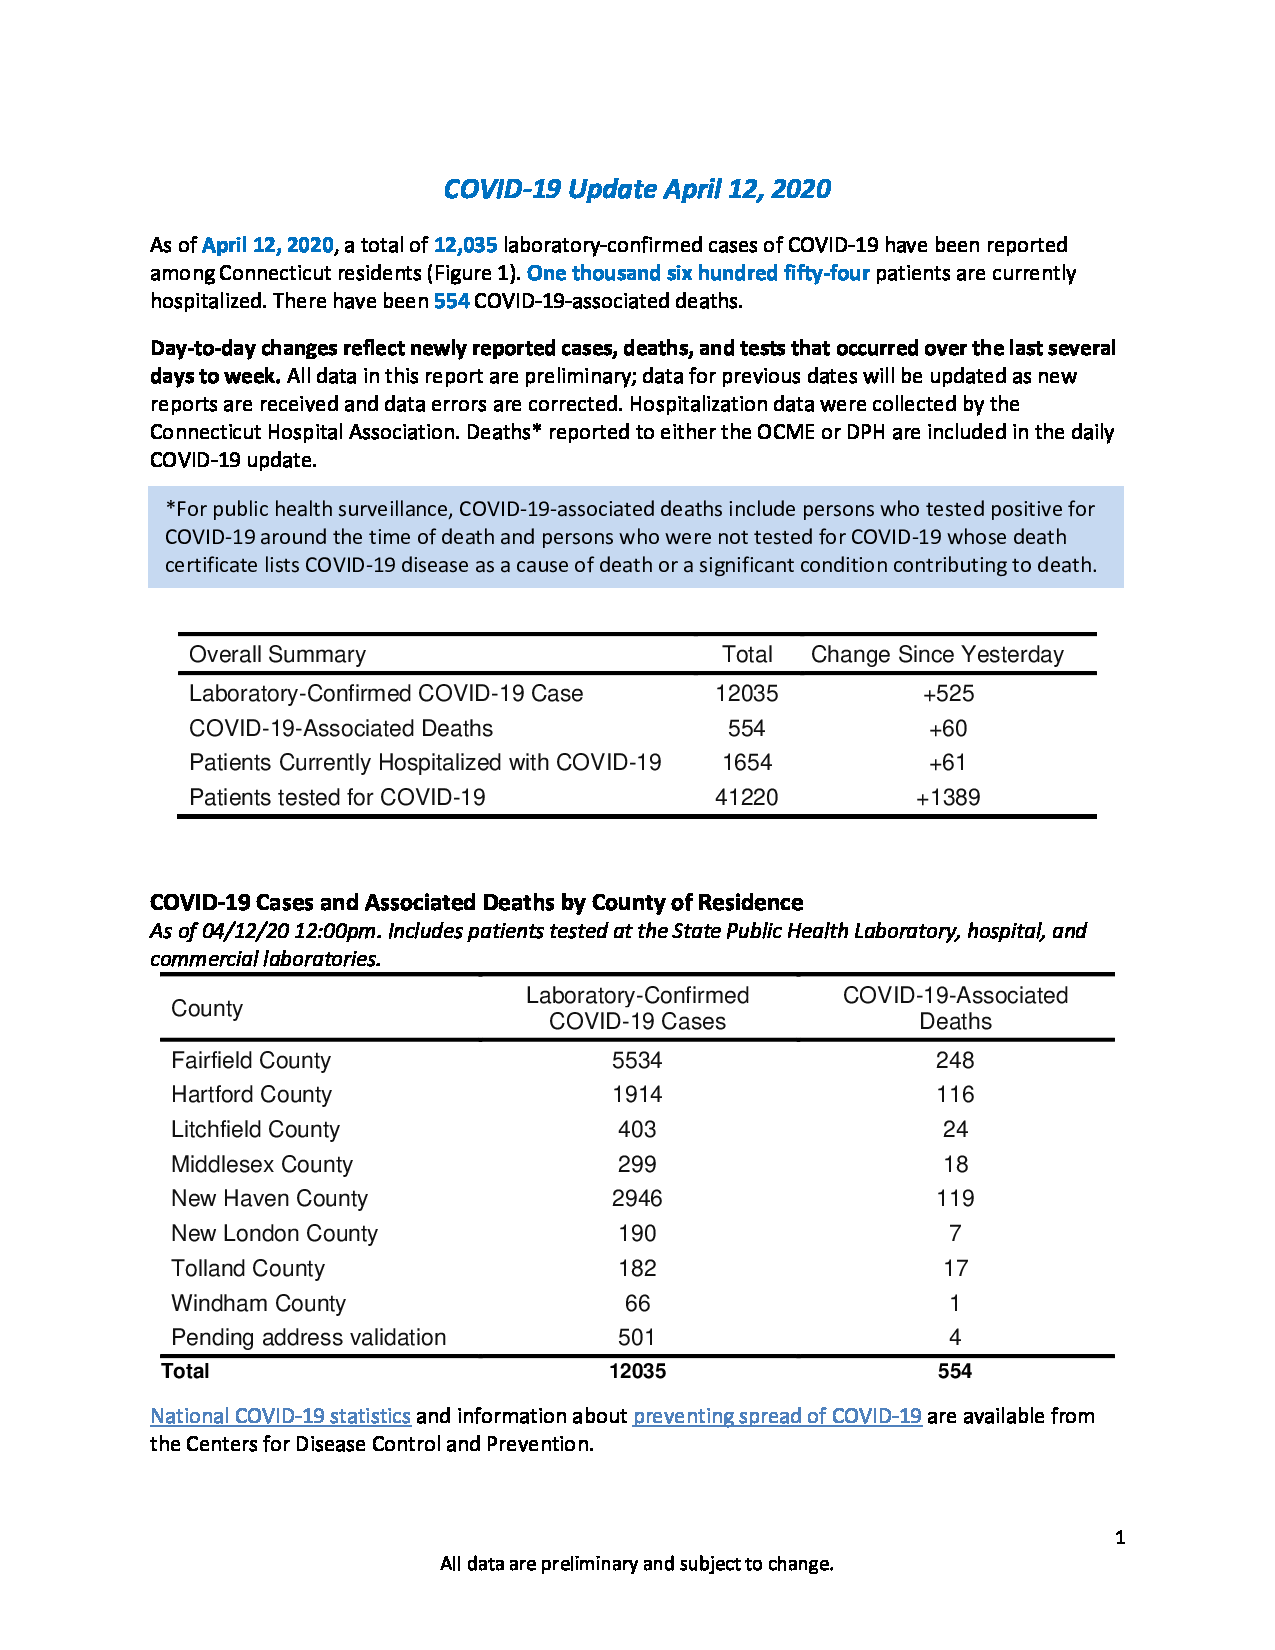

In [59]:
page.to_image(resolution=150)

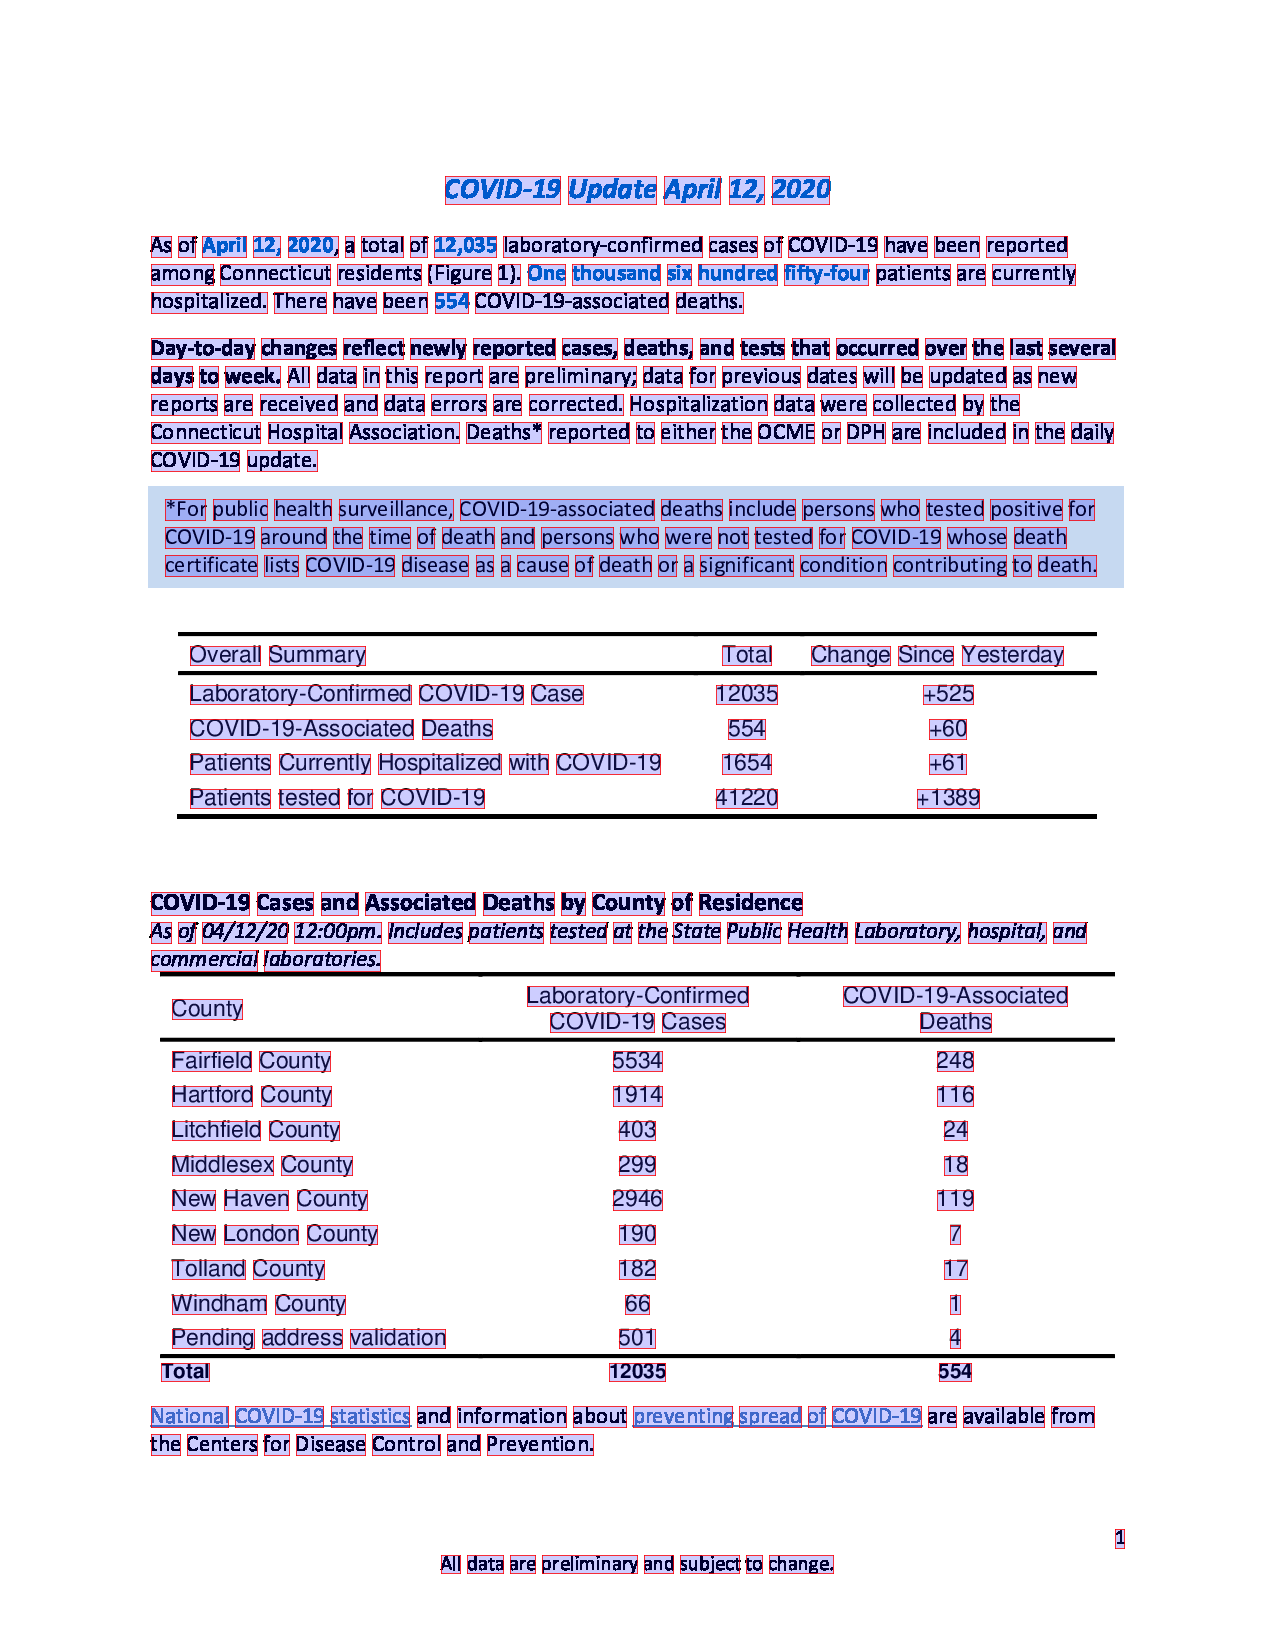

In [60]:
page.to_image(resolution=150).outline_words()